# CamTrapML

> CamTrapML is a Python library for Detecting, Classifying, and Analysing Wildlife [Camera Trap](https://en.wikipedia.org/wiki/Camera_trap) Imagery.

## Installation

    $ pip install camtrapml

## Features

### Loading Data

Search for images in a directory, load an image and create a thumbnail.

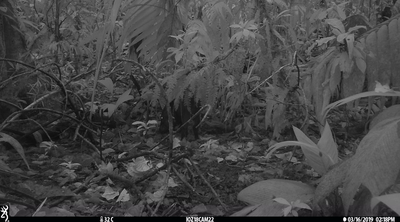

In [1]:
%load_ext autoreload
%autoreload

from camtrapml.dataset import ImageDataset
from camtrapml.image.utils import load_image, thumbnail

imageset = ImageDataset(
    name="Test Images",
    path="test/fixtures/images",
)

image_paths = list(imageset.enumerate_images())

thumbnail(load_image(image_paths[0]))

### EXIF Extraction

EXIF extraction is a common task in gathering the metadata such as each image's timestamp, camera model, focal length, etc. Some researchers write labelling into the EXIF data. CamTrapML doesn't assist with writing to EXIF. However, there is functionality for extracting it for analysis and building datasets for training new models from previously labelled images.

ExifTool is required for this package to work. Installation instructions can be found [here](https://exiftool.org/install.html).

Three methods are available for extracting EXIF data from images. Each with different performance characteristics.

**Method 1: Individual Images**

In [2]:
from camtrapml.image.exif import extract_exif

exif = extract_exif(image_paths[0])
exif

/home/vlucet/.cache/pypoetry/virtualenvs/camtrapml-ABGyQkzp-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'SourceFile': 'test/fixtures/images/IMG_0040.JPG',
 'ExifTool:ExifToolVersion': 12.4,
 'ExifTool:Warning': '[minor] Unrecognized MakerNotes',
 'File:FileName': 'IMG_0040.JPG',
 'File:Directory': 'test/fixtures/images',
 'File:FileSize': 144873,
 'File:FileModifyDate': '2022:09:06 20:33:16-04:00',
 'File:FileAccessDate': '2022:09:06 20:33:16-04:00',
 'File:FileInodeChangeDate': '2022:09:06 20:33:16-04:00',
 'File:FilePermissions': 100775,
 'File:FileType': 'JPEG',
 'File:FileTypeExtension': 'JPG',
 'File:MIMEType': 'image/jpeg',
 'File:ExifByteOrder': 'II',
 'File:ImageWidth': 1280,
 'File:ImageHeight': 711,
 'File:EncodingProcess': 2,
 'File:BitsPerSample': 8,
 'File:ColorComponents': 3,
 'File:YCbCrSubSampling': '1 1',
 'JFIF:JFIFVersion': '1 1',
 'JFIF:ResolutionUnit': 1,
 'JFIF:XResolution': 72,
 'JFIF:YResolution': 72,
 'EXIF:Make': 'Prometheus',
 'EXIF:Model': 'BTC5HDP',
 'EXIF:Orientation': 1,
 'EXIF:XResolution': 72,
 'EXIF:YResolution': 72,
 'EXIF:ResolutionUnit': 2,
 'EXIF:So

**Method 2: Multiple Images**

`extract_multiple_exif` passes a list of image paths to ExifTool and returns a list of dictionaries containing the EXIF data. This is faster than `extract_exif` when multiple images are being processed as it only passes the list of image paths to ExifTool once, rather than spawning a new process for each image.

In [3]:
from camtrapml.image.exif import extract_multiple_exif

exif = extract_multiple_exif(image_paths)
exif[0]

{'SourceFile': 'test/fixtures/images/IMG_0040.JPG',
 'ExifTool:ExifToolVersion': 12.4,
 'ExifTool:Warning': '[minor] Unrecognized MakerNotes',
 'File:FileName': 'IMG_0040.JPG',
 'File:Directory': 'test/fixtures/images',
 'File:FileSize': 144873,
 'File:FileModifyDate': '2022:09:06 20:33:16-04:00',
 'File:FileAccessDate': '2022:09:06 20:33:16-04:00',
 'File:FileInodeChangeDate': '2022:09:06 20:33:16-04:00',
 'File:FilePermissions': 100775,
 'File:FileType': 'JPEG',
 'File:FileTypeExtension': 'JPG',
 'File:MIMEType': 'image/jpeg',
 'File:ExifByteOrder': 'II',
 'File:ImageWidth': 1280,
 'File:ImageHeight': 711,
 'File:EncodingProcess': 2,
 'File:BitsPerSample': 8,
 'File:ColorComponents': 3,
 'File:YCbCrSubSampling': '1 1',
 'JFIF:JFIFVersion': '1 1',
 'JFIF:ResolutionUnit': 1,
 'JFIF:XResolution': 72,
 'JFIF:YResolution': 72,
 'EXIF:Make': 'Prometheus',
 'EXIF:Model': 'BTC5HDP',
 'EXIF:Orientation': 1,
 'EXIF:XResolution': 72,
 'EXIF:YResolution': 72,
 'EXIF:ResolutionUnit': 2,
 'EXIF:So

**Method 3: Multiple Images, Multiple Processes**

When processing large datasets, it's apparent that the bottleneck in extracting the EXIF information tends to be the CPU. This method spawns multiple versions of ExifTool in parallel, each with a batch of image paths. This is faster than `extract_multiple_exif` when processing large datasets as it allows for multiple processes to be spawned and the data extracted in parallel.

In [4]:
from camtrapml.image.exif import extract_multiple_exif_fast

exif = extract_multiple_exif_fast(image_paths)
exif[0]

Extracting EXIF data: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


{'SourceFile': 'test/fixtures/images/IMG_0040.JPG',
 'ExifTool:ExifToolVersion': 12.4,
 'ExifTool:Warning': '[minor] Unrecognized MakerNotes',
 'File:FileName': 'IMG_0040.JPG',
 'File:Directory': 'test/fixtures/images',
 'File:FileSize': 144873,
 'File:FileModifyDate': '2022:09:06 20:33:16-04:00',
 'File:FileAccessDate': '2022:09:06 20:33:16-04:00',
 'File:FileInodeChangeDate': '2022:09:06 20:33:16-04:00',
 'File:FilePermissions': 100775,
 'File:FileType': 'JPEG',
 'File:FileTypeExtension': 'JPG',
 'File:MIMEType': 'image/jpeg',
 'File:ExifByteOrder': 'II',
 'File:ImageWidth': 1280,
 'File:ImageHeight': 711,
 'File:EncodingProcess': 2,
 'File:BitsPerSample': 8,
 'File:ColorComponents': 3,
 'File:YCbCrSubSampling': '1 1',
 'JFIF:JFIFVersion': '1 1',
 'JFIF:ResolutionUnit': 1,
 'JFIF:XResolution': 72,
 'JFIF:YResolution': 72,
 'EXIF:Make': 'Prometheus',
 'EXIF:Model': 'BTC5HDP',
 'EXIF:Orientation': 1,
 'EXIF:XResolution': 72,
 'EXIF:YResolution': 72,
 'EXIF:ResolutionUnit': 2,
 'EXIF:So

### Detection

Various Detection models are available in the `camtrapml.detection` subpackage. These currently include MegaDetector (v4.1, v3 and v2) and support for loading in custom Tensorflow v1.x Object Detection Frozen models.

#### Detection with MegaDetector v4.1

2022-09-07 08:53:20.266417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-07 08:53:21.043209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 08:53:21.043227: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-07 08:53:21.089919: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-07 08:53:21.966899: W tensorflow/stream_executor/platform/de

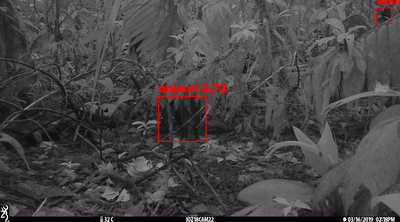

In [5]:
from camtrapml.detection.models.megadetector import MegaDetectorV4_1
from camtrapml.detection.utils import render_detections

with MegaDetectorV4_1() as detector:
    detections = detector.detect(image_paths[0])

thumbnail(
    render_detections(image_paths[0], detections, class_map=detector.class_map)
)

#### Detection with a custom Tensorflow v1.x Object Detection Frozen model

In [ ]:
!cp ~/.camtrapml/models/megadetector/v4.1.0/md_v4.1.0.pb example-custom-model.pb

from camtrapml.detection.models.tensorflow import TF1ODAPIFrozenModel
from camtrapml.detection.utils import render_detections
from pathlib import Path

with TF1ODAPIFrozenModel(
    model_path=Path("example-custom-model.pb").expanduser(),
    class_map={
        1: "animal",
    },
) as detector:
    detections = detector.detect(image_paths[1])

thumbnail(
    render_detections(image_paths[1], detections, class_map=detector.class_map)
)

#### Extract Detections

In [ ]:
from camtrapml.detection.models.megadetector import MegaDetectorV4_1
from camtrapml.detection.utils import extract_detections_from_image

with MegaDetectorV4_1() as detector:
    detections = detector.detect(image_paths[0])

list(extract_detections_from_image(load_image(image_paths[0]), detections))[0]

#### Remove Humans from Images

In order to reduce the risks of identification of humans in line with GDPR, CamTrapML provides the ability to remove humans from images. This is achieved by using the MegaDetector v3+ models to detect humans in the image, and then replacing all pixels in each human detection.

In [ ]:
from camtrapml.detection.models.megadetector import MegaDetectorV4_1
from camtrapml.detection.utils import remove_detections_from_image
from camtrapml.image.utils import load_image, thumbnail
from pathlib import Path

ct_image_with_humans = Path("test/fixtures/human_images/IMG_0254.JPG").expanduser()

with MegaDetectorV4_1() as detector:
    detections = detector.detect(ct_image_with_humans)

human_class_id = 2

thumbnail(
    remove_detections_from_image(
        load_image(ct_image_with_humans),
        [
            detection
            for detection in detections
            if detection["category"] == human_class_id and detection["conf"] > 0.5
        ],
    )
)